# Data analysis of the glacier model

In [1]:
import numpy as np
import matplotlib.pyplot as plt

data = np.load('../data/vary_beta.dat.npz')
print(list(data.keys()))


['inputs', 'uout', 'jrav']


In [6]:
inputs = data['inputs']
uout = data['uout']
jrav = data['jrav']

print('input shape ', inputs.shape)
print('output shape', uout.shape)
print('adjoint shape', jrav.shape)

input shape  (10000, 159)
output shape (10000, 80)
adjoint shape (10000, 80, 159)


In [4]:
inputs.std(axis=0)[-3:]
from utils.plotter import Plotter

plotter = Plotter()

print(uout.min(), uout.max())
print(inputs.min(), inputs.max())
print(jrav.min(), jrav.max())




0.0 1773.939748633615
-4.999999256121194 1773.939748633615
-36.37509660888256 55.04949626260833


In [ ]:

import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
a = jnp.asarray(jrav, dtype=jnp.float64)
jnp.mean(a)

dict_keys(['train_loss', 'train_adj_loss', 'val_loss', 'val_adj_loss', 'train_r2', 'val_r2', 'best_params'])


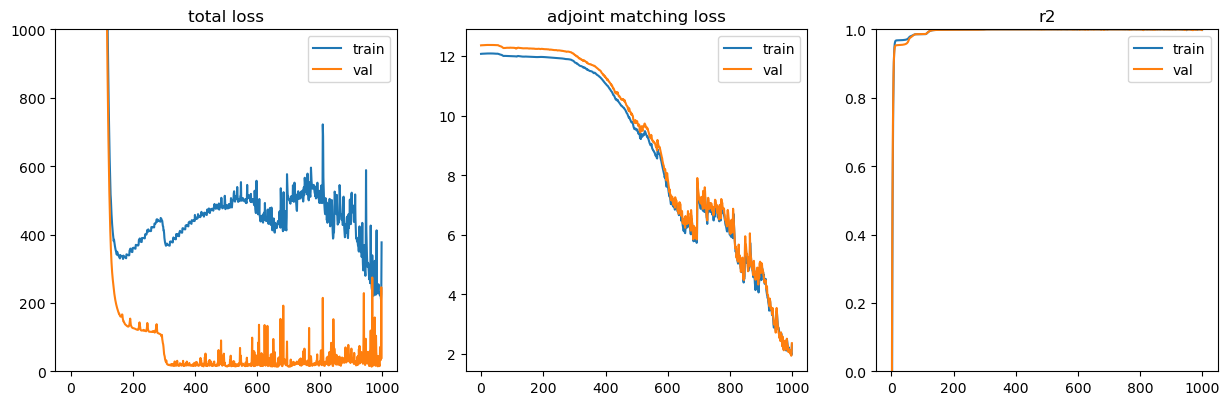

In [39]:
import matplotlib.pyplot as plt
import pickle

with open('./logs/logger_03-15-13_no_cap_lr0.0001_alpha1', 'rb') as f:
    logger = pickle.load(f)

print(logger.keys())

fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].plot(logger['train_loss'], label='train')
ax[0].plot(logger['val_loss'], label='val')
ax[0].set_ylim(0, 1000)
ax[1].plot(logger['train_adj_loss'], label='train')
ax[1].plot(logger['val_adj_loss'], label='val')
ax[2].plot(logger['train_r2'], label='train')
ax[2].plot(logger['val_r2'], label='val')
ax[2].set_ylim(0,1)
ax[0].set_title('total loss')
ax[1].set_title('adjoint matching loss')
ax[2].set_title('r2')
for a in ax:
    a.legend()
    a.set_box_aspect(1)
# fig.savefig('./figs_adjoint/trainingCurve_mixed_nu.pdf', format='pdf')
plt.show()

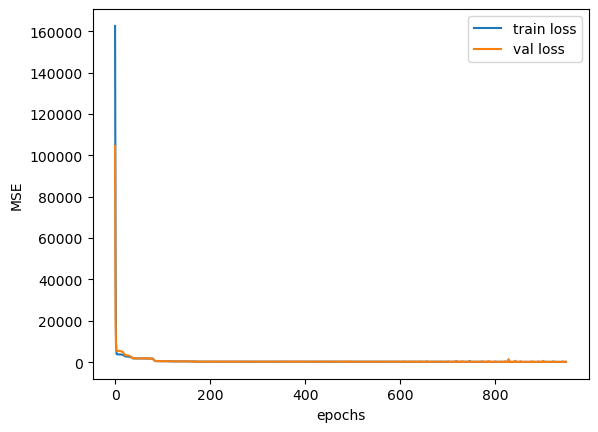

In [17]:
fig, ax = plt.subplots()
ax.plot(logger['train_loss'], label='train loss')
ax.plot(logger['val_loss'], label='val loss')
ax.set_xlabel('epochs')
ax.set_ylabel('MSE')
# ax.set_ylim(-5, 200)
plt.legend()


In [34]:
from adj_match_nn_jax import MLP, Trainer
from utils.data_loader import split_data
from utils.metrics import mean_squared_error, r2, min_max_scaler
import pickle
import optax
import numpy as np

# config.update("jax_enable_x64", True)

data = np.load('../data/vary_beta.dat.npz')
inputs = data['inputs']
uout = data['uout']
jrav = data['jrav']

# x_scaler = logger['x_scaler']
# y_scaler = logger['y_scaler']
# adj_scaler = logger['adj_scaler']


train, val, test = split_data(inputs, uout, jrav)
x = test['x']#x_scaler.transform(test['x'])
#inputs = x_scaler.transform(inputs)


net = MLP([50]*20, in_dim=159, out_dim=80, act_fn='relu')

params = logger['best_params']
test_pred = net.apply(params, x)
# test_pred = y_scaler.inverse_transform(test_pred)
pred_adj = net.nn_adjoint(params, x)
# pred_adj = adj_scaler.inverse_transform(pred_adj)

u_pred = net.apply(params, inputs)
# u_pred = y_scaler.inverse_transform(u_pred)


print('The test MSE is {:.4f}'.format(mean_squared_error(test['y'], test_pred)))
print('The test R2 is {:.4f}'.format(r2(test['y'], test_pred)))
print('The test adj mse is {:.4f}'.format(mean_squared_error(test['adj'], pred_adj)))
print('The test adj R2 is {:4f}'.format(r2(test['adj'], pred_adj)))





The test MSE is 3.9933
The test R2 is 1.0000
The test adj mse is 2.4629
The test adj R2 is 0.569586


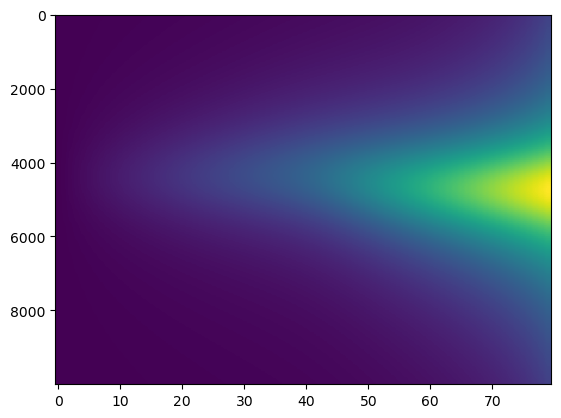

In [40]:
from utils.plotter import Plotter

plotter = Plotter()
# print(uout.shape)
# plotter.heat_map(uout[-5000:],test_pred)
plt.imshow(u_pred, aspect='auto')

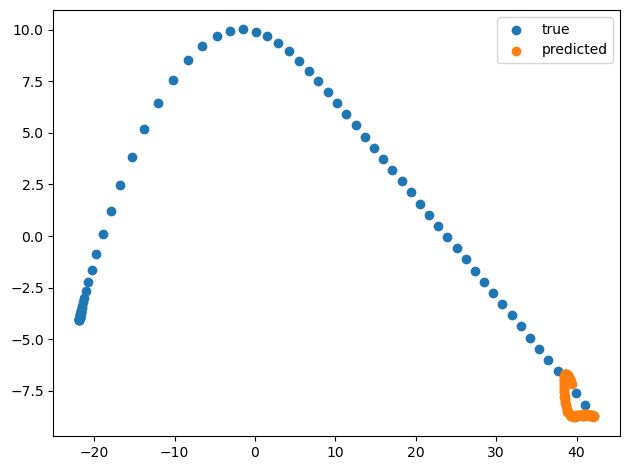

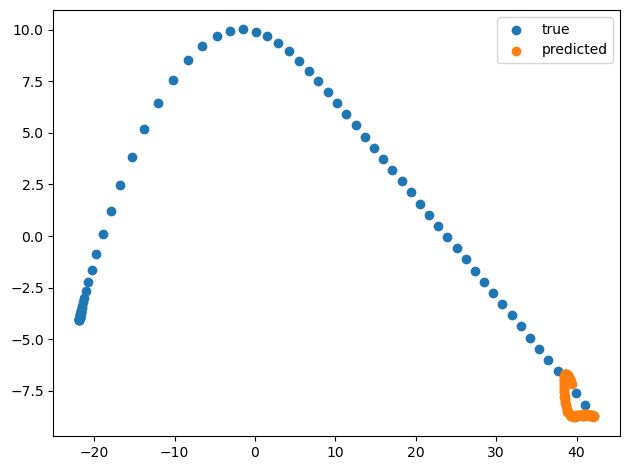

In [36]:
plotter.pca_plot(test['adj'][3], pred_adj[3])